In [227]:
from datetime import datetime
import dask.array as da
import os
import time
import h5py
import numpy as np
import xarray as xr
import downscale as down

import cartopy
import cartopy.feature as cf
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec

In [228]:
resolution = '3h'

In [229]:
extract_box = True # do it only once
# inputfile = os.path.join('..', cdat.tmpa_dir, 'data_tmpa_3h.hdf5')
tmpa_dir = os.path.join('..', 'data', 'tmpa_conus_data')
inputfile = os.path.join(tmpa_dir, 'data_tmpa_3h.hdf5')
outputdir = os.path.join('..', 'data', 'sample_data')
if not os.path.exists(outputdir):
    os.makedirs(outputdir)
# outputfile = os.path.join('..', 'sample_data','okla.nc')
outputfile = os.path.join(outputdir,'okla.nc')

In [230]:
xdata = xr.open_dataarray(outputfile)
xdata

<xarray.DataArray 'array-a54a1d916ea7a467da121195aa8c9ec3' (lon: 5, lat: 5,
                                                            time: 2433)> Size: 243kB
[60825 values with dtype=float32]
Coordinates:
  * lon      (lon) float32 20B -98.62 -98.38 -98.12 -97.88 -97.62
  * lat      (lat) float32 20B 34.38 34.62 34.88 35.12 35.38
  * time     (time) datetime64[ns] 19kB 2008-01-01 ... 2018-10-31T21:00:00

In [241]:
tscale = 24

In [242]:
es = {} # initialize dictionary for storing results
xdata = xdata.where(xdata >= -0.001) # set negative values to np.nan if any
xdaily0 = xdata.resample(time ='{}H'.format(tscale)).sum(dim='time', skipna=False)
xdaily = xdaily0.dropna(dim='time', how='any')
lons = xdata.lon.values
lats = xdata.lat.values
nlon = np.size(lons)
nlat = np.size(lats)
dx = np.abs(lons[1] - lons[0])
dy = np.abs(lats[1] - lats[0])
print(dx)

0.25


/home/arturo/anaconda3/envs/AXE/lib/python3.12/site-packages/xarray/core/groupby.py:668: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  index_grouper = pd.Grouper(


In [243]:
clat = np.mean(lats)
clon = np.mean(lons)
npix = 5

In [244]:
if nlon != nlat:
    print('downscale warning: box sizes are not equal')
if nlon % 2 == 0:
    print('downscale warning: at least one box size has even length')
if (bool(clat) and bool(clon) and clat in lats and clon in lons):
    clat = lats[np.argmin(np.abs(clat - lats))]
    clon = lons[np.argmin(np.abs(clon - lons))]
    # otherwise us the one provided by the
else:
    clat = lats[np.argmin(np.abs(np.mean(lats) - lats))]
    clon = lons[np.argmin(np.abs(np.mean(lons) - lons))]

In [245]:
L1 = down.area_lat_long(clat, clon, dx, dx)[0] # in Km
L1

25.198085541340333

In [246]:
thresh = 1
tsc = xdaily.loc[dict(lat = clat, lon = clon)] # rainfall serie
c_excesses = tsc.values[tsc.values > thresh] - thresh # Values greather than thresh

In [247]:
NCW = down.wei_fit(c_excesses) # Weinbull fit
print(NCW)

(60, 11.7993140329166, 0.8280384818656508)


In [248]:
pws = NCW[0]/xdaily.shape[2]
Ns = int(np.floor(pws*365.25))
Cs = NCW[1]
Ws = NCW[2]
print(pws, Cs, Ws)

0.19672131147540983 11.7993140329166 0.8280384818656508


In [249]:
L0 = 12.5
dt = 3

In [280]:
xdata.shape

(5, 5, 2433)

In [250]:
# ratio between pwet at the grid cell scale to pwet at the target subgrid scale
taylor = down.downscale_pwet(
                xdata, 
                thresh=thresh, # 1
                dt=dt, # 3
                L1=L1, # 25.19
                target_x=L0, 
                target_t=tscale, # 24
                origin_x = 25, # 25
                origin_t = tscale, #24
                ninterp=100, 
                plot=True)

/home/arturo/anaconda3/envs/AXE/lib/python3.12/site-packages/xarray/core/groupby.py:668: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  index_grouper = pd.Grouper(
/home/arturo/anaconda3/envs/AXE/lib/python3.12/site-packages/xarray/core/groupby.py:668: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  index_grouper = pd.Grouper(
/home/arturo/anaconda3/envs/AXE/lib/python3.12/site-packages/xarray/core/groupby.py:668: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  index_grouper = pd.Grouper(
/home/arturo/anaconda3/envs/AXE/lib/python3.12/site-packages/xarray/core/groupby.py:668: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  index_grouper = pd.Grouper(
/home/arturo/anaconda3/envs/AXE/lib/python3.12/site-packages/xarray/core/groupby.py:668: FutureWarning: 'H' is deprecated and will b

In [252]:
taylor['beta']

1.0003613193529621

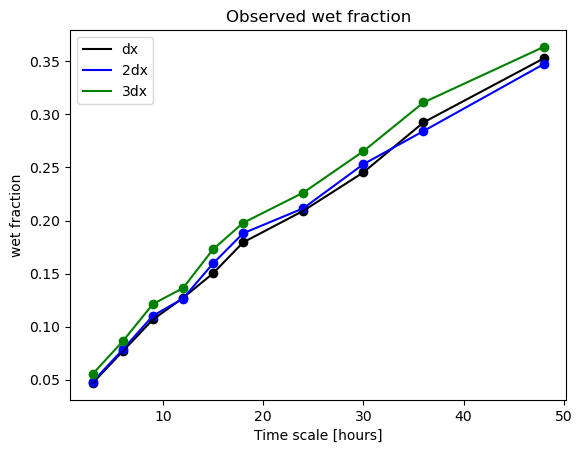

In [253]:
taylor['fig']

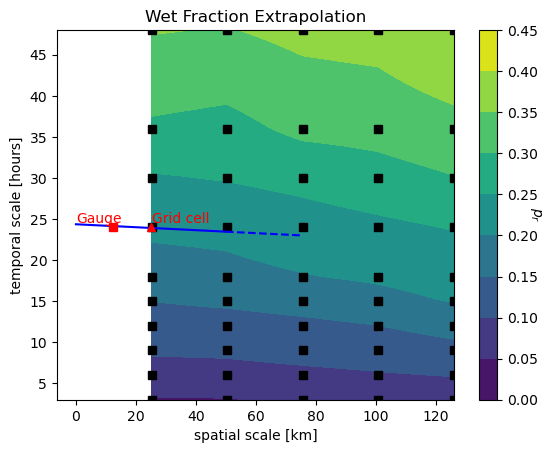

In [254]:
taylor['contour']

In [255]:
acf='mar' # type of autocorrelation
parnames = ['eps', 'alp'] if acf == 'mar' else ['d0', 'mu0']
parnames

['eps', 'alp']

In [256]:
rcorr = down.grid_corr(
                    xdaily, # [5,5,305]
                    plot=True, 
                    thresh=thresh
                    )

rcorr.keys()

dict_keys(['vdist', 'vcorr', 'd0_s', 'mu0_s', 'eps_s', 'alp_s', 'fig'])

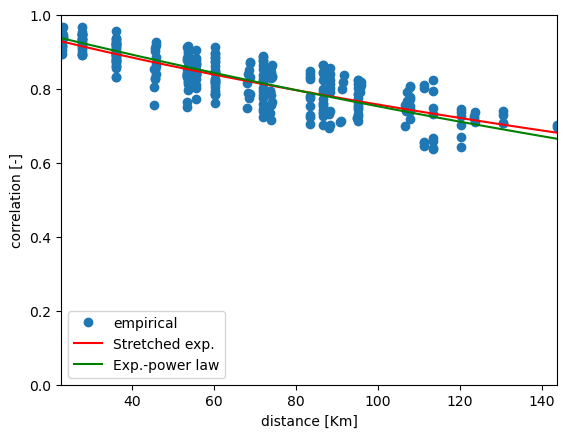

In [258]:
rcorr['fig']

In [259]:
gam_s = down.vrf(L1, L0, (
                            rcorr['{}_s'.format(parnames[0])], # Paramter eps_s from rcorr
                            rcorr['{}_s'.format(parnames[1])]), # Paramter alp_s from rcorr
                acf=acf # type of autocorrelation
                )

gam_s

0.9815303881246795

In [260]:
rcorr['vdist'].shape, rcorr['vcorr'].shape

((300,), (300,))

In [261]:
opt_method='genetic' # optimization method for downscaling the correlation (lbfgsb, genetics or none)
toll = 0.01 #tolerence for optimization of downscaled correlation. (default is 0.005)

dcorr =  down.down_corr(
                        rcorr['vdist'], 
                        rcorr['vcorr'], 
                        L1, 
                        acf=acf,
                        use_ave=True, 
                        opt_method=opt_method, 
                        toll=toll,
                        plot=True)

dcorr.keys()

differential_evolution step 1: f(x)= 0.010552126212970941
differential_evolution step 2: f(x)= 0.004674917842700037
differential_evolution step 3: f(x)= 0.004674917842700037
differential_evolution step 4: f(x)= 0.004674917842700037
differential_evolution step 5: f(x)= 0.004674917842700037
differential_evolution step 6: f(x)= 0.003935054362050862
differential_evolution step 7: f(x)= 0.003935054362050862
Polishing solution with 'L-BFGS-B'
integration domain is zero


dict_keys(['eps_d', 'alp_d', 'success', 'funval', 'fig'])

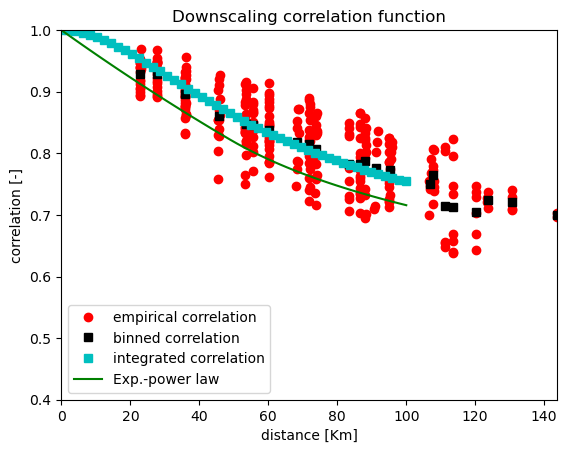

In [262]:
dcorr['fig']

In [263]:
# downscaling the Weibull pdf
print('Downscaling pdf - global Weibull parameters')
par_acf = (dcorr['{}_d'.format(parnames[0])],
            dcorr['{}_d'.format(parnames[1])])
par_acf

Downscaling pdf - global Weibull parameters


(48.45657440313125, 0.19390213716958205)

In [264]:
# Nd, Cd, Wd (downscaled parameters)
# gam = variance reduction function
# fval = function value at the end of numerical minimization
acf='mar' # type of autocorrelation
Nd, Cd, Wd, gam_d, fval_w = down.down_wei(Ns, Cs, Ws, L1, L0, taylor['beta'], par_acf, acf=acf)

In [265]:
print('Downscaling pdf - yearly Weibull parameters')

maxmiss = 100

NCWy, YEARSy = down.fit_yearly_weibull(tsc, thresh=thresh, maxmiss=maxmiss)
NYd, CYd, WYd, _, _ = down.down_wei(NCWy[:,0], NCWy[:,1], NCWy[:,2], L1, L0, taylor['beta'], par_acf, acf=acf)

Downscaling pdf - yearly Weibull parameters


In [266]:
Tr = np.array([2, 5, 10, 20, 50, 100])
Fi = 1 - 1/Tr
Fi

array([0.5 , 0.8 , 0.9 , 0.95, 0.98, 0.99])

In [364]:
res = {} # initialize dictionary for storing results
res['Tr'] = Tr
x0 = 9.0*np.mean(Cd)

In [371]:
# computes the MEV quantile for given non exceedance probability
# single quantile, or array of quantiles
# Fi: non exceedance probability (either scalar or array of values)
# x0: starting guess for numerical solution
# N, C, W: Yearly parameters of MEV distribution
res['mev_d'] = down.mev_quant(Fi, x0, Nd, Cd, Wd, thresh=0)[0] 

res['gam_d'] = gam_d
res['gam_s'] = gam_s
res['beta'] = taylor['beta']
es['Nd'] = Nd

res['Cd'] = Cd # down weibull Scale
res['Wd'] = Wd # down weibull Shape
res['Ns'] = Ns # down weibull Dimension

res['Cs'] = Cs # wei_fit parameters
res['Ws'] = Ws # wei_fit parameters
res['{}_s'.format(parnames[0])] = rcorr['{}_s'.format(parnames[0])]
res['{}_s'.format(parnames[1])] = rcorr['{}_s'.format(parnames[1])]
res['{}_d'.format(parnames[0])] = dcorr['{}_d'.format(parnames[0])]
res['{}_d'.format(parnames[1])] = dcorr['{}_d'.format(parnames[1])]
res['corr_down_success'] = dcorr['success']
res['corr_down_funval'] =  dcorr['funval']
res['w_down_funval'] = fval_w[0]
res['thresh'] = thresh
res['clat'] = clat
res['clon'] = clon

In [269]:
res['beta']

1.0003613193529621

In [270]:
res['mev_d'], Fi

(array([ 76.89378059, 100.57580298, 116.90054287, 132.98227288,
        154.35498489, 170.74934873]),
 array([0.5 , 0.8 , 0.9 , 0.95, 0.98, 0.99]))

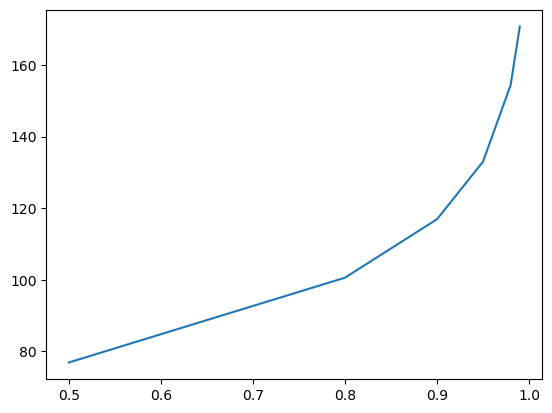

In [271]:
plt.plot(Fi,res['mev_d'])

In [272]:
res['beta'], (res['gam_d']/res['gam_s'])

(1.0003613193529621, 0.9924126233126076)

In [304]:
from scipy.special import gamma

def wei_pdf(x,C,W): 
    ''' compute Weibull pdf with parameters scale C and shape w
    for a scalar OR array input of positive values x'''
    x = np.asarray(x) # transform to numpy array
    is_scalar = False if x.ndim > 0 else True # create flag for output
    x.shape = (1,)*(1-x.ndim) + x.shape # give it dimension 1 if scalar
    pdf = W/C*(x/C)**(W - 1)*np.exp(-(x/C)**W )   
    pdf = pdf if not is_scalar else pdf[0]
    return  pdf

def wei_mean_variance(C,w):
    ''' Computes mean mu and variance var
    of a Weibull distribution with parameter scale C and shape w
    -or repeat for all the elements for same-dim arrays C and W
    NOTE: C and w need to have the same dimension e data type'''
    C = np.asarray(C)
    w = np.asarray(w)  
    # if C is scalar, we return both scalars
    is_C_scalar = False if C.ndim > 0 else True    
    C.shape = (1,)*(1-C.ndim) + C.shape
    w.shape = (1,)*(1-w.ndim) + w.shape
    # compute mean and variance  
    mu    = C/w*gamma(1/w)
    var   = C**2/w**2*(2*w*gamma(2/w)-(gamma(1/w))**2)
    mu    = mu  if not is_C_scalar else mu[0]
    var   = var if not is_C_scalar else var[0]
    return mu,var 

def wei_cdf(q, C, w):# modified order
    ''' returns the non exceedance probability of quantiles q (scalar or array)
    for a Weibull distribution with shape w and scale C'''
    q         = np.asarray(q)
    is_scalar = False if q.ndim > 0 else True 
    cdf       = 1 - np.exp(-(q/C)**w)
    cdf       = cdf  if not is_scalar else cdf[0]
    return cdf


def wei_random_quant(length,C,w):
    ''' generates a vector of length 'length' of 
    quantiles randomly extracted from a Weibull distr with par C, w
    if length = 1, returns a scalar'''
    Fi = np.random.rand(length)
    xi = ( -np.log(1-Fi))**(1/w)*C
    xi    = xi if length > 1 else xi[0]
    return xi

def mev_cdf(quant, N, C, W, potmode = True, thresh = 0):
    '''----------------------------------------------------------------
    computes the mev cdf (cumulative distribution function):
    given::
        quant: quantile for which I compute the non exceedance probability
        N,C,W: arrays of yearly parameters of the mev distribution
        potmode: if True, considers the distributions of value above threshold (default is True)
            (In practice if potmode=True, the distribution of excesses over threshold is computed
            and then from it the cdf is computed for the effective quantile = quant - thresh)
        thresh: threshold for defining ordinary events (default is zero)
    returns::
        mev_cdf: non exceedance probability for the given quantile
    ----------------------------------------------------------------'''
    quant       = np.asarray(quant)
    is_scalar   = False if quant.ndim > 0 else True
    quant.shape = (1,)*(1-quant.ndim) + quant.shape      
    nyears      = N.shape[0]
    if potmode:
        quant = quant - thresh # Probability for given excess
    m = np.size(quant)
    mev_cdf = np.zeros(m)
    for ii in range (m):
        mev_cdf[ii]     = np.sum( ( 1 - np.exp(-(quant[ii]/C)**W ))**N ) / nyears
    mev_cdf     =  mev_cdf  if not is_scalar else  mev_cdf[0]
    return mev_cdf

In [348]:
def mev_quant2(Fi, x0, N, C, W, thresh=1):
    '''--------------------------------------------------------------------
    computes the MEV quantile for given non exceedance prob. in Fi
    arguments:
    Fi: non exceedance probability (either scalar or array of values)
    x0: starting guess for numerical solution
    N, C, W: Yearly parameters of MEV distribution
    potmode: if True, considers the distributions of value above threshold (default is False)
    (In practice if potmode=True, the distribution of excesses over threshold is computed
    and then from it the cdf is computed for the effective quantile = quant - thresh)
    thresh: threshold for defining ordinary events (default is zero)
    returns:
    quant -> single quantile, or array of quantiles
    flags -> flag = 0 if everything is ok, = 1 if convergence problems
    when It happens, a different x0 should be used.
    ---------------------------------------------------------------------'''
    Fi = np.asarray(Fi)
    is_scalar = False if Fi.ndim > 0 else True
    Fi.shape = (1,)*(1-Fi.ndim) + Fi.shape
    m = np.size(Fi)
    quant = np.zeros(m)
    flags = np.zeros((m), dtype = bool) # flag for the convergence of numerical solver
    for ii in range(m):
        myfun     = lambda y: down.mev_fun(y,Fi[ii],N,C,W)
        res       = down.sc.optimize.fsolve(myfun, x0, full_output = True)
        quant[ii] = res[0]
        info      = res[1]
        fval      = info['fvec']
        if fval > 1e-5:
            print('mevd_quant:: ERROR - fsolve does not work -  change x0')
            flags[ii] = 1
    quant = quant + thresh
    quant  = quant if not is_scalar else quant[0]
    flags  = flags if not is_scalar else flags[0]
    return quant, flags

In [377]:
Tr_test = np.arange(1,(len(tsc)+1))

Tr_test = np.linspace(1,100,(len(tsc)))
Fi2 = 1 - 1/Tr_test

TEST = mev_quant2(Fi2, 0, Nd, Cd, Wd, thresh=0)[0] 
TEST = TEST/np.nanmax(TEST)

/tmp/ipykernel_8422/1734426315.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  quant[ii] = res[0]


In [378]:
WEI_CDF = wei_cdf(np.arange(1,(len(tsc)+1)), res['Cd'], res['Ws'])
WEI_CDF.shape

(305,)

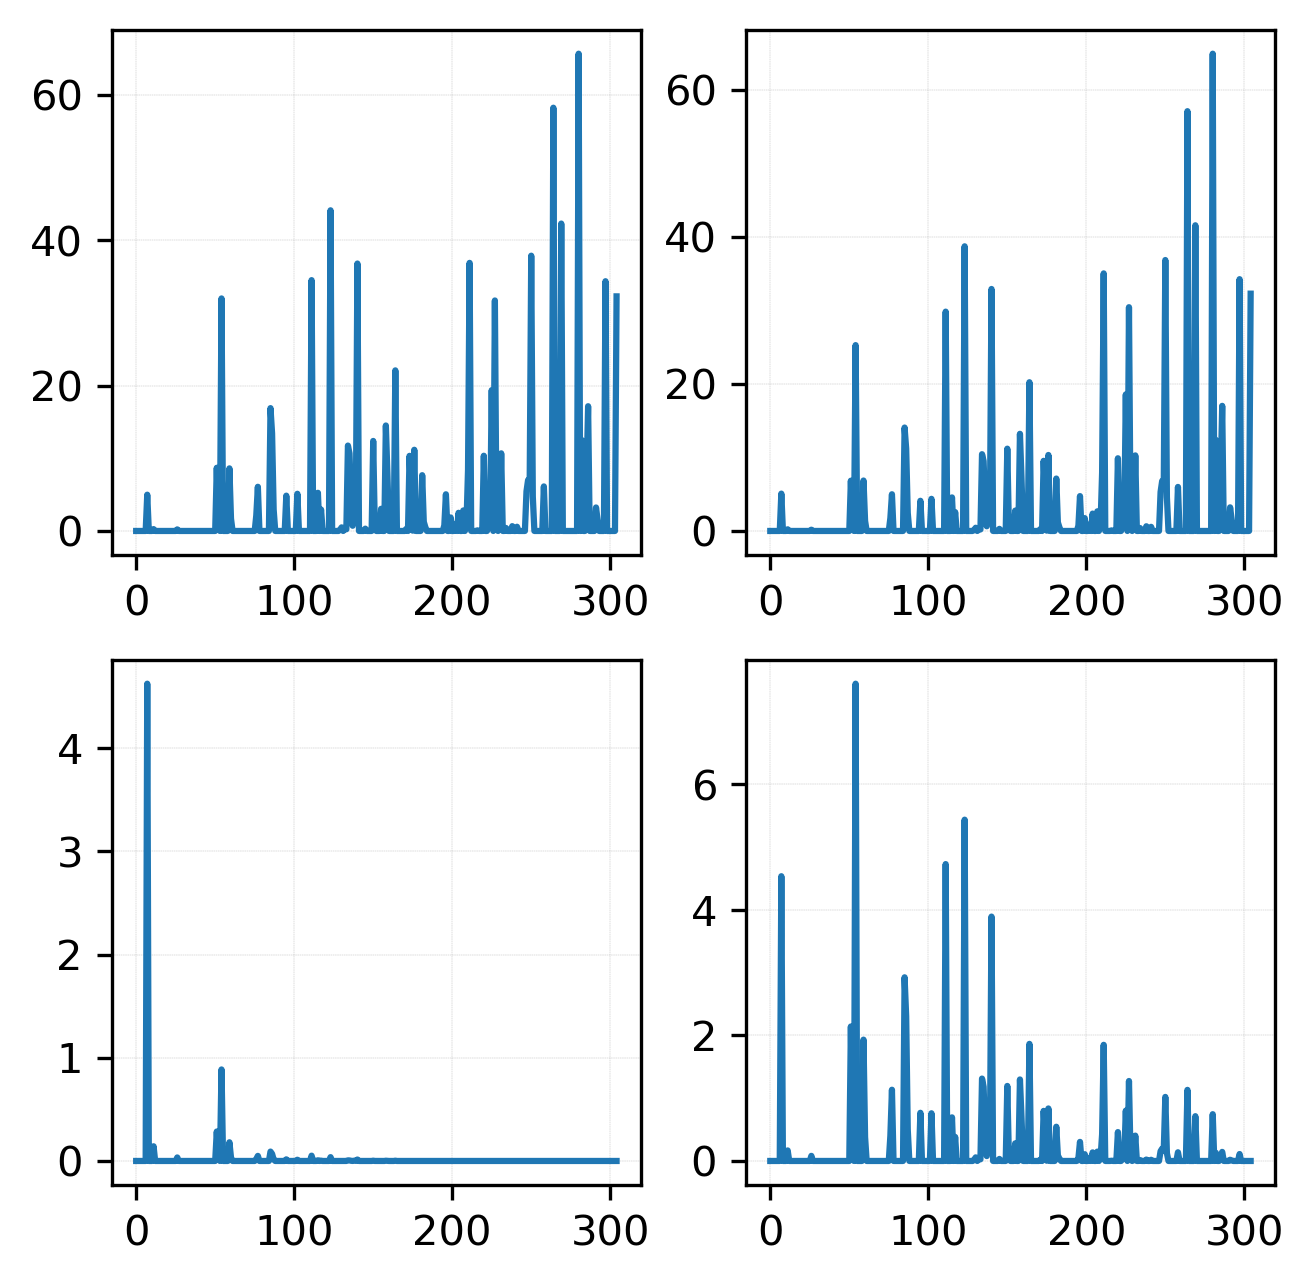

In [387]:
fig = plt.figure(figsize=(5,5),dpi=300)
gs = gridspec.GridSpec(2,2)

# =================================================================
ax1 = plt.subplot(gs[0, 0])
# plt.plot(tsc)
plt.plot(tsc*WEI_CDF)
plt.grid(linewidth=0.1, linestyle='--')

# =================================================================
ax1 = plt.subplot(gs[0, 1])
# plt.plot(tsc)
plt.plot(tsc*TEST)
plt.grid(linewidth=0.1, linestyle='--')

# =================================================================
ax1 = plt.subplot(gs[1, 0])
plt.plot(tsc - tsc*WEI_CDF)
plt.grid(linewidth=0.1, linestyle='--')

# =================================================================
ax1 = plt.subplot(gs[1, 1])
plt.plot(tsc - tsc*TEST)
plt.grid(linewidth=0.1, linestyle='--')

In [97]:
ntimes = len(xdata['time'])
ntimes

2433

In [117]:
WEI_PDF = wei_pdf(np.arange(1,len(tsc)+1), res['Cd'], res['Ws'])
WEI_CDF = wei_cdf(res['mev_d'], res['Cd'], res['Ws'])
WEI_DIS = mev_cdf(res['mev_d'], np.arange(1,len(tsc)+1), res['Cd'], res['Ws'])

In [154]:
# Create a random rainfall series using Weibull prameters
WEI_RAN = wei_random_quant(len(tsc), res['Cd'], res['Ws'])

xi = np.sort(WEI_RAN)
fi = np.arange(1,len(WEI_RAN) + 1)/(len(WEI_RAN) + 1)

# check mean and variance
musam  = np.mean(WEI_RAN)
varsam = np.var(WEI_RAN)
muteo, varteo = wei_mean_variance(res['Cd'], res['Ws'])
print('sample   :', musam, varsam)
print('theorical:', muteo, varteo)

sample   : 12.994547808966484 256.05552585605517
theorical: 12.786251819525786 241.25053338657276


In [136]:
Fi = np.linspace(0.3,0.99,1000)
DOWN_quantiles = down.mev_quant(Fi, x0, Nd, Cd, Wd, thresh=thresh)[0]

In [152]:
OBS_xi = np.sort(tsc)
OBS_fi = np.arange(1,len(tsc) + 1)/(len(tsc) + 1)

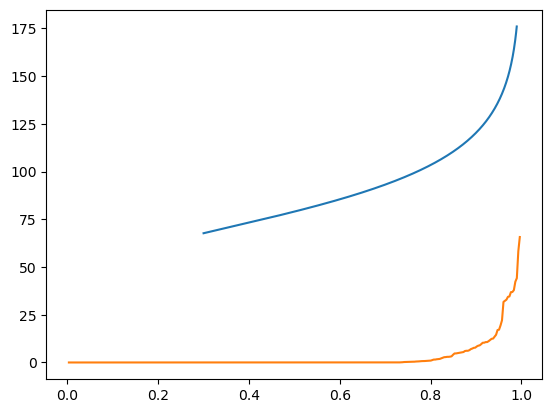

In [153]:
plt.plot(Fi, DOWN_quantiles)
plt.plot(OBS_fi, OBS_xi)

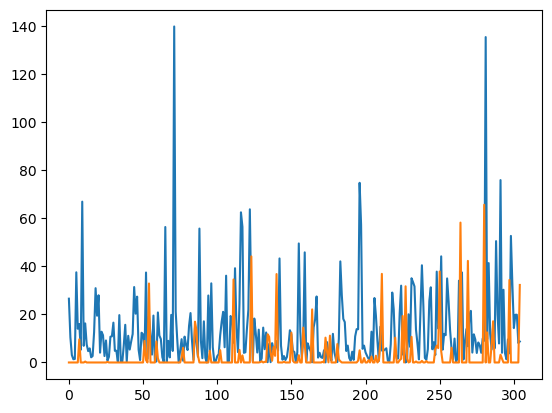

In [115]:
plt.plot(WEI_RAN)
plt.plot(tsc)